In [1]:
import numpy as np
import sys
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sn
import scipy as sp
from tqdm import tqdm
import glob
import xarray as xr
import pickle


from fair import *
from fair.scripts.data_retrieval import *

from pandas import DataFrame

%matplotlib inline

# SSP simulations
In this notebook, we run FaIRv2 simulations for several key Shared Socioeconomic Pathways.

## Insert parameter set
Here we insert a parameter set of 1,000 members for the CONSTRAINED ensemble. More info on the constrain applied & FULL perturbed parameter ensemble in FULL-compute, global-warming-index & FULL-constrain notebooks.

In [2]:
param_categories = pd.read_csv('../../leach-et-al-2021-main/aux/FaIRv2.0.0-alpha_RF_categories.csv',index_col=0,skiprows=1,names=['source','category'])
param_categories.loc['Total'] = 'Total'

In [3]:

## and here we extract the parameter sets
    
gas_params = pd.read_hdf('../../leach-et-al-2021-main/CONSTRAINED_set_for_FaIRv2.0.0-alpha/gas-parameters-x10000.h5')
athousand_members = gas_params.columns.levels[0][:1000] # this should be a list of 1000 unique members
athousand_gas_params = gas_params.reindex(athousand_members,axis=1,level=0) # slice out those members from the 10,000 member ensemble

#print(athousand_gas_params)

In [4]:
thermal_params = pd.read_hdf('../../leach-et-al-2021-main/CONSTRAINED_set_for_FaIRv2.0.0-alpha/thermal-parameters-x10000.h5')
athousand_thermal_params = thermal_params.reindex(athousand_members,axis=1,level=0)

#print(athousand_thermal_params)

In [5]:
extforc_sfs = pd.read_hdf('../../leach-et-al-2021-main/CONSTRAINED_set_for_FaIRv2.0.0-alpha/external-forcing-scalings-x10000.h5')
athousand_extforc_sfs = extforc_sfs.reindex(athousand_members,axis=1) # took out 'level = 0' because I got an error message saying that 'Index' has no variable 'levels'.

#print(athousand_extforc_sfs)

In [6]:
CONSTRAINED_gas_set = athousand_gas_params.copy()
CONSTRAINED_thermal_set = athousand_thermal_params.copy()
CONSTRAINED_extforc_sfs = athousand_extforc_sfs.copy()


## Run SSPs
We use SSP emission data from the RCMIP protocol.
We run FaIR over SSP1-19, SSP1-26, SSP2-45, SSP3-70, SSP5-85 as these cover a wide range of forcing/emission scales (including SLCPs).
Reference:
Nicholls, Z. R. J., Meinshausen, M., Lewis, J., Gieseke, R., Dommenget, D., Dorheim, K., … Xie, Z. (2020). Reduced complexity model intercomparison project phase 1: Protocol, results and initial observations. Geoscientific Model Development Discussions, 1–33. https://doi.org/10.5194/gmd-2019-375

In [24]:
def run_ssp(ssp, fix_temps = False):

    ## retrieve the data for the ssp
    emms = RCMIP_to_FaIR_input_emms(ssp).interpolate().loc[1750:2200] #!!
    ## rebase emission-driven forcings & species with natural emissions to 1750
    rebase_species = ['so2','nox','co','nmvoc','bc','nh3','oc','nox_avi','methyl_bromide','methyl_chloride','chcl3','ch2cl2']
    emms.loc[:,rebase_species] -= emms.loc[1750,rebase_species]

    ssp_erf = pd.read_csv('https://raw.githubusercontent.com/Priestley-Centre/ssp_erf/master/SSPs/ERF_'+ssp+'_1750-2500.csv',index_col=0,dtype=float).loc[:2200] # !!

    ## generate prescribed erf timeseries
    ## dimension is [time,source,mem]
    extforc_arr = (CONSTRAINED_extforc_sfs.values[None] * ssp_erf[['land_use','volcanic','solar']].values[...,None])
    extforc_ts = pd.DataFrame(data=extforc_arr.sum(axis=1),index=ssp_erf.index,columns=pd.MultiIndex.from_product([CONSTRAINED_extforc_sfs.columns,['forcing']]))

    emms = pd.concat([emms]*N_sets,axis=1,keys=extforc_ts.columns.levels[0])

    result = run_FaIR(emissions_in=emms,
                      forcing_in=extforc_ts,
                      gas_parameters=CONSTRAINED_gas_set,
                      thermal_parameters=CONSTRAINED_thermal_set,
                      show_run_info=False, fix_temps = fix_temps)
    
    LUC_rf = pd.DataFrame(data=extforc_arr[:,0,:],index=ssp_erf.index,columns=pd.MultiIndex.from_product([CONSTRAINED_extforc_sfs.columns,['forcing']])).droplevel(axis=1,level=1).stack().sort_index()
    
    rf = (result['RF']-result['RF'].loc[1850]).stack(level=0).groupby(param_categories.category.to_dict(),axis=1).sum().sort_index()
    rf['aer'] = rf.aci+rf.ari
    rf['anthro'] = rf.aer+rf.bc_on_snow+rf.carbon_dioxide+rf.contrails+rf.methane+rf.nitrous_oxide+rf.other_wmghgs+rf.ozone+rf.strat_h2o+LUC_rf
    
    rf = rf.stack().unstack(level=1).quantile([0.05,0.166,0.5,0.833,0.95],axis=1).stack().swaplevel(0,1).sort_index().T
    
    # T = (result['T']-result['T'].loc[1850:1900].mean()).quantile([0.05,0.166,0.5,0.833,0.95],axis=1).T
    
    
    # T_EoC = (result['T'].loc[2081:2200].mean()-result['T'].loc[1850:1900].mean()).quantile([0.05,0.166,0.5,0.833,0.95]) #!!
    
    return result, T, T_EoC

In [ ]:
N_sets = 1000

plot_T = []
plot_T_EoC = []
plot_RF = []

# choose_ssps = ['ssp119','ssp126','ssp434','ssp245','ssp370','ssp585']
#choose_ssps = ['ssp119','ssp126','ssp434','ssp245']
choose_ssps = ['ssp434']

results_dict = {}


for ssp in choose_ssps:
    # get no geoengineering data
    result_no_geo = run_ssp(ssp, fix_temps = False)
    
#     plot_T += [T.copy()]
#     plot_T_EoC += [T_EoC.copy()]
#     plot_RF += [rf.copy()]
    
    results_dict[ssp, 'no_geo'] = result_no_geo
    
    # get geoengineering data
    result_geo15 = run_ssp(ssp, fix_temps = 1.5)

    results_dict[ssp, 'geo15'] = result_geo15
    
# plot_T = pd.concat(plot_T,axis=1,keys=choose_ssps)
# plot_T_EoC = pd.concat(plot_T_EoC,axis=1,keys=choose_ssps)
# plot_RF = pd.concat(plot_RF,axis=1,keys=choose_ssps)

100%|██████████| 450/450 [00:08<00:00, 54.37 timestep/s]


In [ ]:
results_dict['ssp434','no_geo']['C']['mem100190','carbon_dioxide']

#results_dict


In [ ]:
results_dict['ssp434','geo15']['C']['mem100190','carbon_dioxide']


In [ ]:
#results_dict['ssp434','no_geo']['C'].keys()

results_dict['ssp434','no_geo']['T']['mem100190',]



In [ ]:
results_dict['ssp434','geo15']['T']['mem100190',]



In [12]:
scenario_co2_dict = {}

scenario_temp_dict = {}

for key in results_dict.keys():
    
    result = results_dict[key]
    
    #obtain concentrations 
    concentrations = result['C']

    co2_conc_dict = {}

    for member in athousand_members:
        parameter_set = concentrations[member]
        co2_conc = parameter_set['carbon_dioxide']
        co2_conc_dict[member] = co2_conc.values 
        
    scenario_co2_dict[key] = co2_conc_dict
    
    #obtain temperatures
    temperatures = result['T']
    
    temp_dict = {}
    
    for member in athousand_members:
        temp_value = temperatures[member,]
        temp_dict[member] = temp_value.values
    
    scenario_temp_dict[key] = temp_dict
    


scenario_temp_dict['ssp434', 'geo15']  


{'mem100190': array([ 1.95691148e-02,  4.81226620e-02,  6.03628030e-02,  6.31060746e-02,
         5.96319734e-02,  5.17256878e-02,  3.01675632e-02,  1.47449111e-02,
         2.59969887e-02,  4.81626422e-02,  7.00769074e-02,  8.54474113e-02,
         3.74028827e-02, -3.00124113e-02, -3.22692944e-02, -1.08137343e-02,
        -1.59796554e-02, -4.08405476e-02, -3.50994095e-02,  7.34068914e-04,
         2.95094173e-02,  4.63887469e-02,  6.24517470e-02,  7.34092320e-02,
         7.56399283e-02,  7.12224217e-02,  6.48685396e-02,  6.11593618e-02,
         6.48676228e-02,  7.94210710e-02,  9.98318147e-02,  1.16288730e-01,
         1.24478228e-01,  1.47556218e-02, -2.75686510e-01, -4.26587152e-01,
        -3.48721459e-01, -2.54717089e-01, -1.72083719e-01, -1.00206769e-01,
        -4.26500520e-02, -2.62950024e-03,  2.38571197e-02,  4.10109544e-02,
         4.96556396e-02,  5.13826083e-02,  4.10120756e-02,  1.86376354e-02,
         4.40032835e-03,  6.71428001e-03,  1.60886229e-02,  2.82095140e-02,

In [13]:
# emissions = result['Emissions']
# keys = athousand_members
# co2_emms_array = []

# for member in athousand_members:
#     parameter_set = emissions[member]
#     co2_emms = parameter_set['carbon_dioxide']
#     co2_emms_array.append(co2_emms) # what do I have to do to get this into a set of columns rather than one very long list?

# # parameter_set = concentrations['mem100190']
# # co2_conc= parameter_set['carbon_dioxide']


In [14]:
scenario_temp_dict_no_geo = scenario_temp_dict['ssp434', 'no_geo']

scenario_temp_dict_geo15 = scenario_temp_dict['ssp434', 'geo15']


num_years_no_geo = 0
num_years_geo15 = 0

num_years_no_geo_dict = {}

num_years_geo15_dict = {}

for member in scenario_temp_dict_no_geo:
    temp_values = scenario_temp_dict_no_geo[member]
    
#    num_years_no_geo = 0
    
    for value in temp_values:
        if float(value) >= 1.5:
            num_years_no_geo += 1
    
#     num_years_no_geo_dict[member] = num_years_no_geo       

        
#print(num_years_no_geo_dict)  

for member in scenario_temp_dict_geo15:
    temp_values = scenario_temp_dict_geo15[member]
    
#     num_years_geo15 = 0
    
    for value in temp_values:
        if float(value) >= 1.5:
            num_years_geo15 += 1
    
#     num_years_geo15_dict[member] = num_years_geo15
  
print(num_years_geo15)
print()
print(num_years_no_geo)

155293

155293


In [107]:

column_names = athousand_members

T_diff_array = pd.DataFrame()

def createList(r1, r2):
    return [item for item in range(r1, r2+1)]
      
# Driver Code
r1, r2 = 1750, 2200
years = createList(r1, r2)


for j in range(1000):
    T_peak_shave_col = T_peak_shave.iloc[:,j]
#     print('Column of T with 1.5 limit')
#     print(T_peak_shave_col)
    # print()
    # print()
    
    T_OG_col = T_OG.iloc[:,j]
#     print('Column of T_OG')
#     print(T_OG_col)
    # print()
    # print()
    
    current_col = []
    

    for i in range(len(T_peak_shave_col)):
        diff = T_OG_col.values[i] - T_peak_shave_col.values[i]
        current_col.append(diff)
       

    Series_col = pd.Series(current_col, index = years)
    T_diff_array.append(Series_col, athousand_members[j])
            

T_diff_array

# HOW DO I APPEND VALUES/LISTS/COLUMNS TO A DATAFRAME???

TypeError: Can only append a Series if ignore_index=True or if the Series has a name

In [37]:
all_columns = []

all_columns.append(T_diff_col1)
all_columns.append(T_diff_col2)
all_columns.append(T_diff_col3)
all_columns.append(T_diff_col4)
all_columns.append(T_diff_col5)

# years = []
# calc = 1750

# while int(calc) < 2201:
#     years.append(calc)
#     calc += 1

# T_diff = DataFrame(all_columns).transpose()
# T_diff.columns = ['0.050','0.116','0.500','0.833','0.950']


# T_diff

In [38]:
all_columns

[[0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,

## make the plots!
import some additional data - MAGICC7.1.0-beta, observed GMST & CMIP6

In [206]:
## import RCMIP phase I MAGICC7.1.0-beta runs
## get MAGICC7.1.0 data to benchmark
MAGICC_defaults = pd.read_csv('../../leach-et-al-2021-main/aux/input-data/RCMIP/data_results_phase-1_magicc7_rcmip_phase-1_magicc7.1.0.beta_v1-0-0.csv').drop(['Model','Unit','Climatemodel','Region'],axis=1).set_index(['Scenario','Variable']).reindex(['esm-'+x+'-allGHG' for x in choose_ssps],level=0).rename(dict(zip(['esm-'+x+'-allGHG' for x in choose_ssps],choose_ssps)),level=0)
RCMIP_outputmap = pd.read_csv('../../leach-et-al-2021-main/aux/FaIRv2.0.0-alpha_RCMIP_inputmap.csv',index_col=0)
RCMIP_forcmap = pd.read_csv('../../leach-et-al-2021-main/aux/FaIRv2.0.0-alpha_RCMIP_forcmap.csv',index_col=0)
RCMIP_forcmap.loc['anthro'] = 'Effective Radiative Forcing|Anthropogenic'

# get MAGICC temp
MAGICC_T = MAGICC_defaults.xs('Surface Air Temperature Change',level=1).T
MAGICC_T.index = MAGICC_T.index.astype(int)
MAGICC_T -= MAGICC_T.loc[1850:1900].mean()

# get MAGICC rf
RCMIP_forc_keys = RCMIP_forcmap.loc[['carbon_dioxide','methane','nitrous_oxide','aci','ari','trop_o3','strat_o3','bc_on_snow','strat_h2o','contrails','f_gases','montreal_gases','anthro']].RCMIP_forc_key.to_dict()
RCMIP_forc_keys = {v: k for k, v in RCMIP_forc_keys.items()}
MAGICC_rf = MAGICC_defaults.rename(RCMIP_forc_keys,level=1).reindex(RCMIP_forc_keys.values(),level=1).unstack(level=0)
MAGICC_rf.loc['aer'] = MAGICC_rf.loc['aci']+MAGICC_rf.loc['ari']
MAGICC_rf.loc['f_gases'] = MAGICC_defaults.reindex(RCMIP_forcmap.loc[RCMIP_forcmap.RCMIP_forc_key.str.split('|',expand=True)[2]=='F-Gases'].RCMIP_forc_key.values,level=1).groupby(level=0).sum().stack().swaplevel(0,1).sort_index()
MAGICC_rf.loc['montreal_gases'] = MAGICC_defaults.reindex(RCMIP_forcmap.loc[RCMIP_forcmap.RCMIP_forc_key.str.split('|',expand=True)[2]=='Montreal Gases'].RCMIP_forc_key.values,level=1).groupby(level=0).sum().stack().swaplevel(0,1).sort_index()
MAGICC_rf.loc['ozone'] = MAGICC_rf.loc['trop_o3']+MAGICC_rf.loc['strat_o3']
MAGICC_rf.loc['other_wmghgs'] = MAGICC_rf.loc['f_gases']+MAGICC_rf.loc['montreal_gases']
MAGICC_rf.loc['contrails'] = np.full(MAGICC_rf.shape[1],9999)
MAGICC_rf = MAGICC_rf.stack().T.swaplevel(0,1,axis=1).sort_index(axis=1).replace(9999,np.nan)
MAGICC_rf.index = MAGICC_rf.index.astype(int)

In [207]:
## import observed GMST datasets
## retrieve chosen dataset:

GMST_sets = []

GMST = xr.open_dataset('../../leach-et-al-2021-main/aux/input-data/Temperature-observations/HadCRUT.5.0.1.0.analysis.ensemble_series.global.monthly.nc').tas.to_pandas().T
GMST_sets += [GMST.resample('y').mean().median(axis=1).rename('HadCRUT5')]

GMST = pd.concat([pd.read_csv(x,header=None,delim_whitespace=True,index_col=0,usecols=[0,1]).iloc[:,0] for x in sorted(glob.glob('../../leach-et-al-2021-main/aux/input-data/Temperature-observations/HadCRUT.4.6.0.0.monthly_ns_avg_realisations/*.txt'))],axis=1,keys=np.arange(100))
GMST.index = pd.to_datetime(GMST.index)
GMST_sets += [GMST.resample('y').mean().median(axis=1).rename('HadCRUT4')]

GMST = pd.read_csv('../../leach-et-al-2021-main/aux/input-data/Temperature-observations/aravg.mon.land_ocean.90S.90N.v5.0.0.202101.asc',delim_whitespace=True,names=['date','month','anom','unc_full'],usecols=[0,1,2,3]).apply(pd.to_numeric)
GMST.index = pd.to_datetime(GMST.date.astype(str)+'-'+GMST.month.astype(str))
GMST_sets += [GMST.sort_index().loc['1880':'2020','anom'].resample('y').mean().rename('NOAA')]

GMST = pd.read_csv('../../leach-et-al-2021-main/aux/input-data/Temperature-observations/GLB.Ts+dSST.csv',skiprows=2,names=['year']+list(range(1,13)),usecols=range(13),index_col=0).unstack().reset_index()
GMST.index = pd.to_datetime(GMST.year.astype(str)+'-'+GMST.level_0.astype(str))
GMST_sets += [GMST.sort_index().loc['1880':'2020',0].astype(float).resample('y').mean().rename('GISTEMP')]

GMST=pd.read_csv('../../leach-et-al-2021-main/aux/input-data/Temperature-observations/had4_krig_ensemble_v2_0_0.txt',delim_whitespace=True,index_col=0,names=['date']+list(range(100)))
GMST.index = pd.to_datetime(GMST.index.astype(int).astype(str)+'-'+np.ceil((GMST.index%1)*12).astype(int).astype(str))
# current version of the dataset has a null member at 32
GMST = GMST.drop(32,axis=1)
GMST_sets += [GMST.resample('y').mean().median(axis=1).rename('CW')]

# NB this uses air temps above sea ice, not water temps
GMST = pd.read_csv('../../leach-et-al-2021-main/aux/input-data/Temperature-observations/Land_and_Ocean_complete.txt',skiprows=76,skipfooter=2057,delim_whitespace=True,usecols=[0,1,2,3],names=['date','month','anom','unc_full'])
GMST.index = pd.to_datetime(GMST.date.astype(str)+'-'+GMST.month.astype(str))
GMST_sets += [GMST.sort_index().loc['1850':'2020','anom'].resample('y').mean().rename('Berkeley')]

GMST_sets = pd.concat(GMST_sets,axis=1)

# set all datasets relative to the same 20th century change
GMST_sets-=GMST_sets.loc['1900':'1999'].mean()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.


In [208]:
## import CMIP6 global mean data
def get_CMIP6_data_from_MAG(fname):
    with open(fname) as myFile:
        for num, line in enumerate(myFile, 1):
            if line.lstrip()[:5]=='YEARS':
                startline = num
                break
                
    info_index = tuple(fname.split('/')[-1].split('_')[1:6])
    data_out = pd.read_csv(fname,skiprows=startline-1,delim_whitespace=True,index_col=0).WORLD
    data_out.name = info_index

    return data_out

CMIP6_ssp_files = glob.glob('../../leach-et-al-2021-main/aux/input-data/CMIP6/ssp*/average-year-mid-year/CMIP6/ScenarioMIP/*/*/*/*/*/*/*/*/*.MAG')
CMIP6_ssp_data = []

for fname in tqdm(CMIP6_ssp_files):
    CMIP6_ssp_data += [get_CMIP6_data_from_MAG(fname)]
    
CMIP6_ssp_data = pd.concat(CMIP6_ssp_data,axis=1)

CMIP6_hist_files = glob.glob('../../leach-et-al-2021-main/aux/input-data/CMIP6/historical_tas/average-year-mid-year/CMIP6/CMIP/*/*/*/*/*/*/*/*/*.MAG')
CMIP6_hist_data = []

for fname in tqdm(CMIP6_hist_files):
    CMIP6_hist_data += [get_CMIP6_data_from_MAG(fname)]
    
CMIP6_hist_data = pd.concat(CMIP6_hist_data,axis=1)

CMIP6_baseline = CMIP6_hist_data.groupby(level=2,axis=1).mean().loc[1850:1900].mean()

CMIP6_ssp_data_by_model = CMIP6_ssp_data.groupby(level=[2,3],axis=1).mean().apply(lambda x: x - CMIP6_baseline.loc[x.name[0]] if x.name[0] in CMIP6_baseline.index else np.nan).dropna(axis=1,how='all')

100%|██████████| 527/527 [00:07<00:00, 70.47it/s]


In [209]:
matplotlib.rcParams['font.family']='Helvetica'
matplotlib.rcParams['font.size']=11

matplotlib.rcParams['axes.formatter.limits']=-3,3

matplotlib.rcParams['legend.frameon']=False

plt.rcParams['pdf.fonttype'] = 42

### ERF plot

AttributeError: 'list' object has no attribute 'columns'

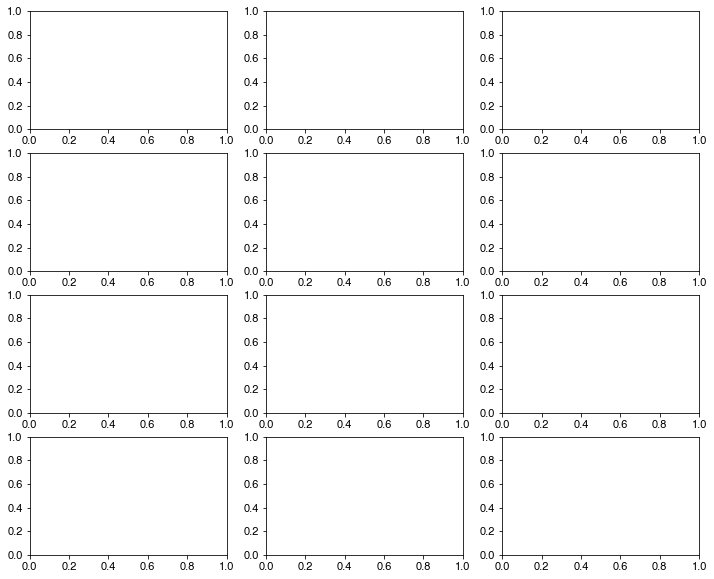

In [210]:
fig,ax = plt.subplots(4,3,figsize=(12,10))

colors= {'ssp858':'#7570b3','ssp434':'#d95f02','ssp245':'#e7298a','ssp119':'#66a61e','ssp126':'#1b9e77','history':'grey'} #changed ssp370 to ssp434 here
map_forc_names = dict(zip(plot_RF.columns.levels[1].tolist(),['total','aerosol-cloud interaction','total aerosol','total anthropogenic','aerosol-radation interaction','black carbon on snow','CO$_2$','contrails','CH$_4$','N$_2$O','other WMGHGs','ozone','stratospheric H$_2$O from CH$_4$']))
forc_order = ['carbon_dioxide','methane','nitrous_oxide','other_wmghgs','ozone','strat_h2o','ari','aci','aer','bc_on_snow','contrails','anthro']

for ssp in choose_ssps:
    for i,forc in enumerate(forc_order):
        ax.flatten()[i].plot(plot_RF.loc[2014:2200,(ssp,forc,0.5)],color=colors[ssp],label=ssp) # !!
        ax.flatten()[i].fill_between(np.arange(2014,2201),*plot_RF.loc[2014:2200,(ssp,forc,[0.05,0.95])].values.T,color=colors[ssp],alpha=0.2,lw=0) # !!
        ax.flatten()[i].plot(np.arange(2014,2201),plot_RF.loc[2014:2200,(ssp,forc,[0.05,0.95])].values,color=colors[ssp],alpha=0.5,lw=1) # !!
        
        ax.flatten()[i].plot(MAGICC_rf.loc[2014:2200,(ssp,forc)],color=colors[ssp],ls=':',lw=1.2,alpha=0.5) # !!
        
        
for i,forc in enumerate(forc_order):
    ax.flatten()[i].plot(plot_RF.loc[1850:2014,('ssp245',forc,0.5)],color=colors['history'],label='historical')
    ax.flatten()[i].fill_between(np.arange(1850,2015),*plot_RF.loc[1850:2014,('ssp245',forc,[0.05,0.95])].values.T,color=colors['history'],alpha=0.2,lw=0)
    ax.flatten()[i].plot(np.arange(1850,2015),plot_RF.loc[1850:2014,('ssp245',forc,[0.05,0.95])].values,color=colors['history'],alpha=0.5,lw=1)
    
    ax.flatten()[i].plot(MAGICC_rf.loc[1850:2014,('ssp245',forc)],color=colors['history'],ls=':',lw=1.2,alpha=0.5)
    
    ax.flatten()[i].set_xlim(1850,2200) # !!
    sn.despine()
    ax.flatten()[i].set_ylabel(map_forc_names[forc],fontweight='bold')
    
[a.set_xticklabels([]) for a in ax[:-1].flatten()]
[a.set_xlabel('year') for a in ax[-1]]
[a.ticklabel_format(style='plain') for a in ax[-1]]
ax[0,0].plot([],[],'k:',label='MAGICC7.1.0.beta')
ax[0,0].legend()
plt.tight_layout()

#[fig.savefig('../../docs/manuscript/figures/Fig9.'+x,dpi=600,bbox_inches='tight') for x in ['png','pdf']]
''

### Temp plot

In [ ]:
fig = plt.figure(figsize=(8,6))
gs = fig.add_gridspec(1, 20,wspace=0.2)

## timeseries plot
ax = fig.add_subplot(gs[0,:-3])

for ssp in choose_ssps:
    ax.plot(plot_T.loc[2014:2200,(ssp,0.5)],color=colors[ssp],label=ssp) # !!
    ax.fill_between(np.arange(2014,2201),*plot_T.loc[2014:2200,(ssp,[0.05,0.95])].values.T,color=colors[ssp],alpha=0.2,lw=0) # !!
    ax.plot(np.arange(2014,2201),plot_T.loc[2014:2200,(ssp,[0.05,0.95])].values,color=colors[ssp],alpha=0.5,lw=1) #!!
    
    ax.plot(MAGICC_T.loc[2014:2200,(ssp)],color=colors[ssp],ls=':',lw=1.2,alpha=0.5) #!!
        
ax.plot(plot_T.loc[1850:2014,('ssp245',0.5)],color=colors['history'],label='historical')
ax.fill_between(np.arange(1850,2015),*plot_T.loc[1850:2014,('ssp245',[0.05,0.95])].values.T,color=colors['history'],alpha=0.2,lw=0)
ax.plot(np.arange(1850,2015),plot_T.loc[1850:2014,('ssp245',[0.05,0.95])].values,color=colors['history'],alpha=0.5,lw=1)    

ax.plot(MAGICC_T.loc[1850:2014,('ssp245')],color=colors['history'],ls=':',lw=1.2,alpha=0.5)

ax.plot(np.arange(1850,2021),(GMST_sets-GMST_sets.loc['1850':'1900'].mean()).mean(axis=1).values,'.k',ms=2,label='observed GMST')
ax.plot([],[],'k:',label='MAGICC7.1.0.beta')

# ax formatting
ax.set_xlim(1850,2200) #!!
ax.legend(loc='upper left')
ax.set_ylabel('temperature anomaly relative to 1850-1900 / K')
ax.set_xlabel('year')
ax.ticklabel_format(style="plain")
sn.despine(ax=ax)

## boxplot
ax1 = fig.add_subplot(gs[0,-3:])
box_width = 0.3
for i,ssp in enumerate(choose_ssps):
    ax1.fill_betweenx(plot_T_EoC.loc[[0.05,0.95],ssp],i,i+box_width,color=colors[ssp],alpha=0.2,lw=0)
    ax1.fill_betweenx(plot_T_EoC.loc[[0.166,0.833],ssp],i,i+box_width,color=colors[ssp],alpha=0.2,lw=0)
    ax1.fill_betweenx([plot_T_EoC.loc[0.5,ssp]]*2,i,i+box_width,color=colors[ssp])
    
    i+=0.4
    ax1.fill_betweenx([CMIP6_ssp_data_by_model.loc[2081:2200].mean().xs(ssp,level=1).min(),CMIP6_ssp_data_by_model.loc[2081:2200].mean().xs(ssp,level=1).max()],i,i+box_width,fc=(0,0,0,0),ec=colors[ssp],lw=0.5) #!!
    ax1.fill_betweenx(CMIP6_ssp_data_by_model.loc[2081:2200].mean().xs(ssp,level=1).quantile([0.166,0.833]),i,i+box_width,fc=(0,0,0,0),ec=colors[ssp],lw=0.5) #!!
    ax1.fill_betweenx([CMIP6_ssp_data_by_model.loc[2081:2200].mean().xs(ssp,level=1).quantile(0.5)]*2,i,i+box_width,color=colors[ssp]) #!!
    
# ax1 formatting
sn.despine(ax=ax1,left=True,bottom=True)
ax1.yaxis.set_ticklabels([])
ax1.yaxis.set_ticks_position('none')
ax1.set_xticks([])

# both axes formatting
[a.set_ylim(-0.5,7) for a in [ax,ax1]]
[a.yaxis.grid(ls=':') for a in [ax,ax1]]

#[fig.savefig('../../docs/manuscript/figures/Fig10.'+x,dpi=600,bbox_inches='tight') for x in ['png','pdf']]
#fig.dpi=180
''

In [ ]:
## get other experiments:
DECK_experiment_data = xr.open_dataset('../../leach-et-al-2021-main/aux/input-data/CMIP6/CMIP6_tuning_data.nc')

In [ ]:
def format_table(x):
    if np.isnan(x):
        return ''
    else:
        return "{:.0f}".format(x)

DECK_table = DECK_experiment_data.tas.sel(time='1850').squeeze().stack(index=['climate_model','scenario','member_id']).to_pandas().groupby(level=[0,1]).count().unstack()
DECK_table.index.name='model'
DECK_table.columns.name='experiment'
    
SSP_table = CMIP6_ssp_data.loc[2081:2100].mean().dropna().groupby(level=[2,3]).count().unstack().replace(np.nan,0).astype(int)
SSP_table.index.name='model'
SSP_table.columns.name='experiment'

CMIP6_member_table = pd.concat([DECK_table,SSP_table],axis=1).replace(np.nan,0).astype(int)
CMIP6_member_table.index.name='model'
CMIP6_member_table.loc['Total models'] = (CMIP6_member_table>0).sum()

CMIP6_member_table#.to_latex('../../docs/manuscript/tables/TabS4',escape=False,bold_rows=True)